# Análisis de Consumo Energético y Clustering con K-Means

## Objetivos del Cuaderno


1. **Validación del Modelo**: Evaluar la calidad de los clusters generados utilizando metodos y visualizaciones adecuadas.
    -  **Visualización de Clusters**: Graficar los clusters generados para observar la distribución de los datos y la separación entre los grupos
        - **Análisis de Componentes Principales (PCA)**: Para la visualizazacion 2D de los cluster

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore")

#### Cargar los datasets

In [2]:
df = pd.read_csv("dataset/features_StandardScaler.csv", index_col='cups')
df_features_final = pd.read_csv("dataset/features_KNNImputer.csv", index_col='cups')
X = df.values

### Elegir con que modelos has entrenado, en futuras versones seran varaibles de entorno

In [3]:
which_model = "spectral_clustering" #Choose beetween "bkmeans" or "kmeans" or "spectral_clustering"

In [4]:
with open("pkls/spectral_clustering_model.pkl", "rb") as f:
    model_final = pickle.load(f)

if hasattr(model_final, 'labels_'):
    labels = model_final.labels_


In [5]:
best_k = model_final.n_clusters
gamma = model_final.gamma if hasattr(model_final, 'gamma') else None

### Variables más influyentes según varianza entre clusters

## Visualización de Resultados de Clustering

In [6]:
colours = {
    0: 'blue',
    1: 'yellow',
    2: 'red'
}
cvec = [colours[label] for label in labels]

### Visualización de Clusters PCA

#### 1. PCA 2D

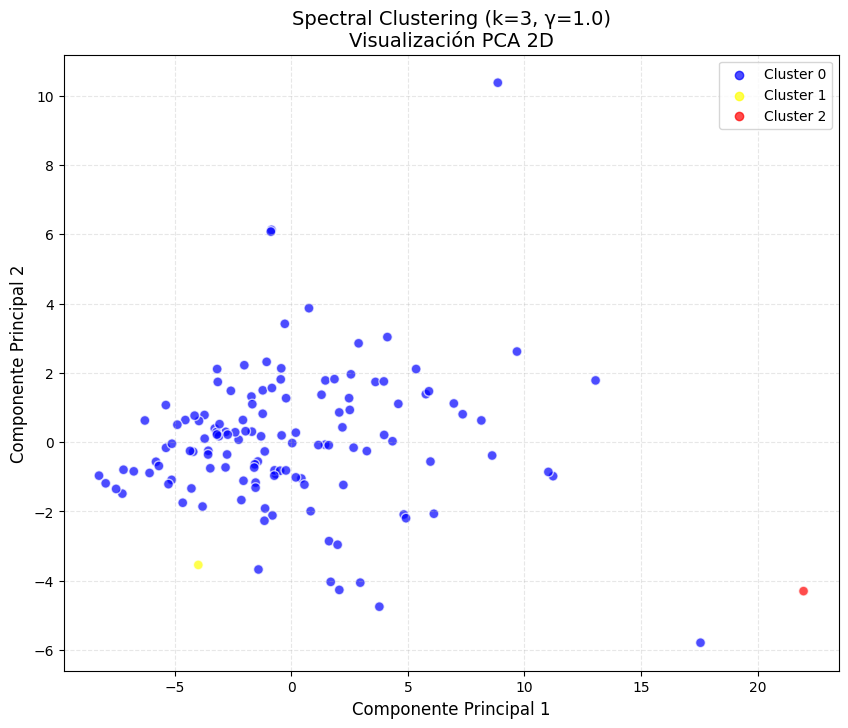

In [7]:
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)
X_principal_2d = pd.DataFrame(X_pca_2d, columns=['P1', 'P2'])

plt.figure(figsize=(10, 8))

scatters = [
    plt.scatter([], [], color='blue', label='Cluster 0', alpha=0.7),
    plt.scatter([], [], color='yellow', label='Cluster 1', alpha=0.7),
    plt.scatter([], [], color='red', label='Cluster 2', alpha=0.7)
]

plt.scatter(X_principal_2d['P1'], X_principal_2d['P2'], c=cvec, alpha=0.7, edgecolors='w', s=50)

plt.title(f'Spectral Clustering (k={best_k}, γ={gamma})\nVisualización PCA 2D', fontsize=14)
plt.xlabel('Componente Principal 1', fontsize=12)
plt.ylabel('Componente Principal 2', fontsize=12)
plt.legend(handles=scatters, loc='best')
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()


#### 2. PCA 3D

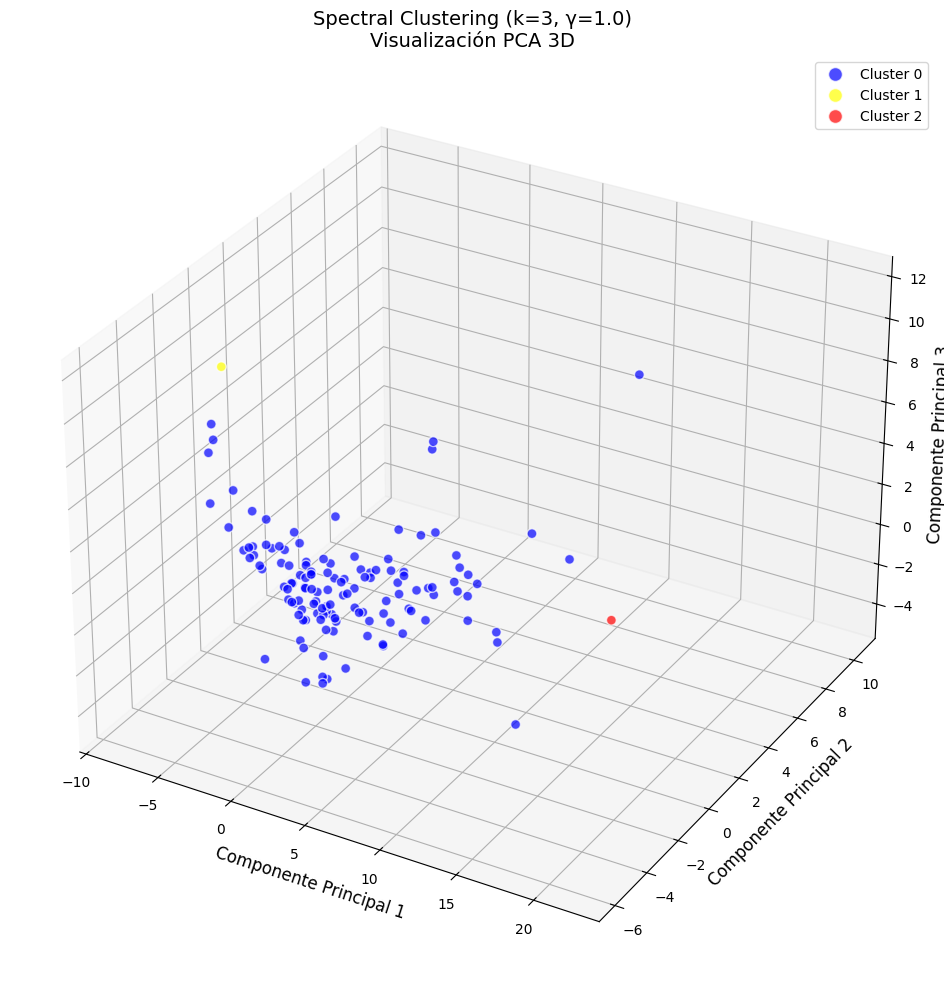

In [8]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X)
X_principal_3d = pd.DataFrame(X_pca_3d, columns=['P1', 'P2', 'P3'])

ax.scatter(X_principal_3d['P1'], X_principal_3d['P2'], X_principal_3d['P3'], c=cvec, alpha=0.7, edgecolors='w', s=50)

ax.set_title(f'Spectral Clustering (k={best_k}, γ={gamma})\nVisualización PCA 3D', fontsize=14)
ax.set_xlabel('Componente Principal 1', fontsize=12)
ax.set_ylabel('Componente Principal 2', fontsize=12)
ax.set_zlabel('Componente Principal 3', fontsize=12)

# Leyenda personalizada para 3D
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0', 
              markerfacecolor='blue', markersize=10, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1', 
              markerfacecolor='yellow', markersize=10, alpha=0.7),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 2', 
              markerfacecolor='red', markersize=10, alpha=0.7)
]

ax.legend(handles=legend_elements, loc='upper right')
plt.tight_layout()
plt.show()

### Guardar cups y cluster asociacion

In [9]:
df_clusters = pd.DataFrame({
    'CUPS': df_features_final.index,
    'CLUSTER': labels
})

cluster_counts = df_clusters['CLUSTER'].value_counts().to_dict()

df_clusters['CLUSTER'] = df_clusters['CLUSTER'].apply(
    lambda x: f"{x} ({cluster_counts[x]})"
)

filename = f'dataset/cluster_cups_sc.csv'
df_clusters.to_csv(filename, index=False)

### Visualización de Clusters de su Consumo Original

In [11]:
df_original = pd.read_csv("dataset/vertical_data.csv", sep=";")

cups_con_nan_invierno = ['ceaddbf817fc', 'd0fbcc1108d8']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_invierno)]

cups_con_nan_otoño = ['83c7fbada9b4', 'b476034a2e3d', 'ba38270a360e']
df_original = df_original[~df_original['cups'].isin(cups_con_nan_otoño)]


df_clusters = df_features_final.reset_index()[['cups']].copy()
df_clusters['cluster'] = labels


df_final = pd.merge(df_original, df_clusters[['cups', 'cluster']], on='cups', how='left')

# Reordenar las columnas para que 'cluster' sea la segunda
column_order = ['cups', 'cluster'] + [col for col in df_final.columns if col not in ['cups', 'cluster']]
df_final = df_final[column_order]

filename = f'dataset/datos_consumo_con_clusters_sc.csv'

df_final.to_csv(filename, index=False, sep=';')

### 1. Distribución de Series por Cluster

📊 Distribución de puntos por cluster:
cluster
0    129
1      1
2      1
Name: count, dtype: int64


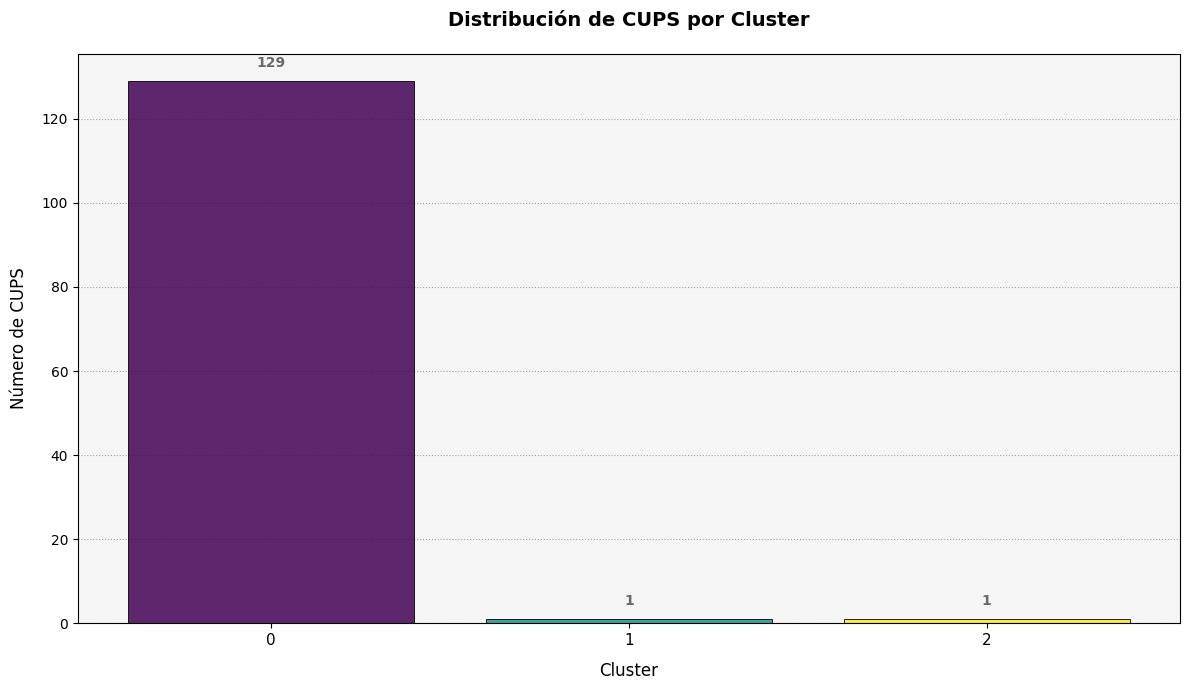

In [12]:
cluster_counts = df_clusters['cluster'].value_counts().sort_index()
print("📊 Distribución de puntos por cluster:")
print(cluster_counts)

plt.figure(figsize=(12, 7))
ax = plt.subplot()

colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_counts)))

bars = ax.bar(
    cluster_counts.index.astype(str),
    cluster_counts.values,
    color=colors,
    edgecolor='black',
    linewidth=0.7,
    alpha=0.85
)

plt.title('Distribución de CUPS por Cluster', fontsize=14, pad=20, fontweight='bold')
plt.xlabel('Cluster', fontsize=12, labelpad=10)
plt.ylabel('Número de CUPS', fontsize=12, labelpad=10)
plt.xticks(fontsize=11)
ax.set_axisbelow(True)
ax.grid(axis='y', linestyle=':', alpha=0.7, color='gray')
ax.set_facecolor('#f5f5f5')
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width()/2,
        height + max(cluster_counts.values)*0.02, 
        f"{int(height):,}", 
        ha='center',
        va='bottom',
        fontsize=10,
        fontweight='bold',
        color='dimgrey'
    )

plt.tight_layout()
plt.show()

### 2. Superposición de Series con Centroides

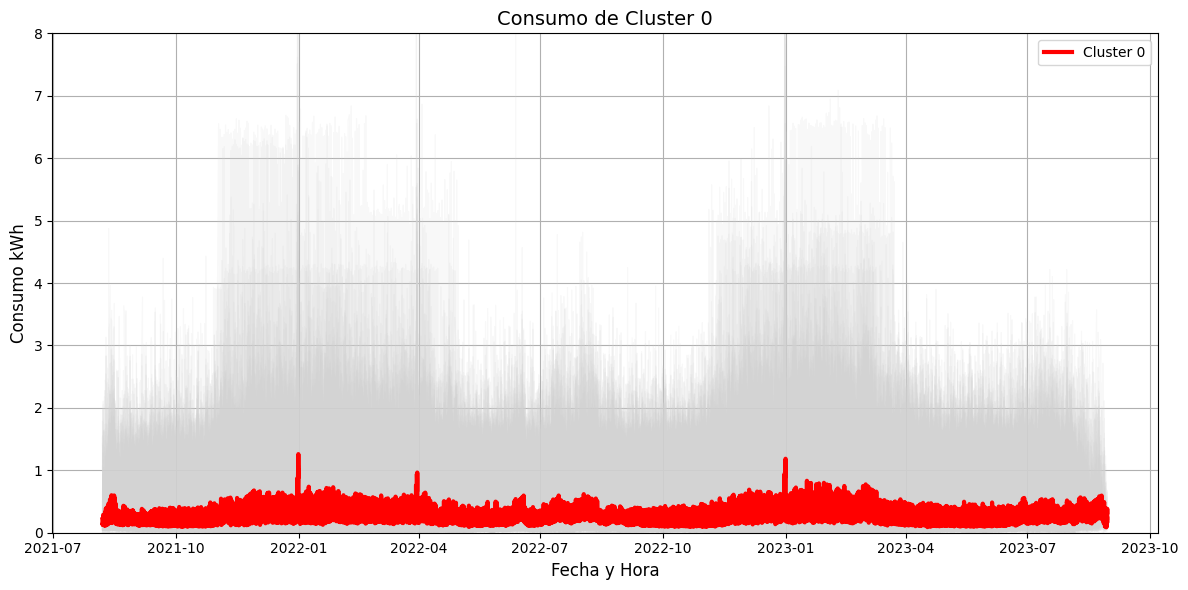

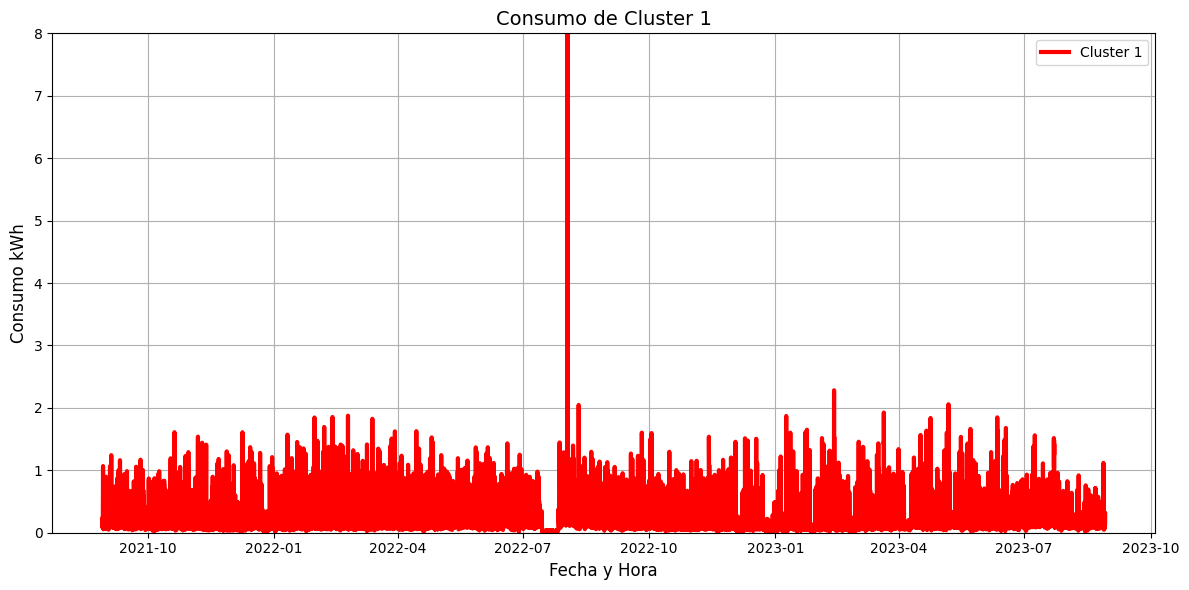

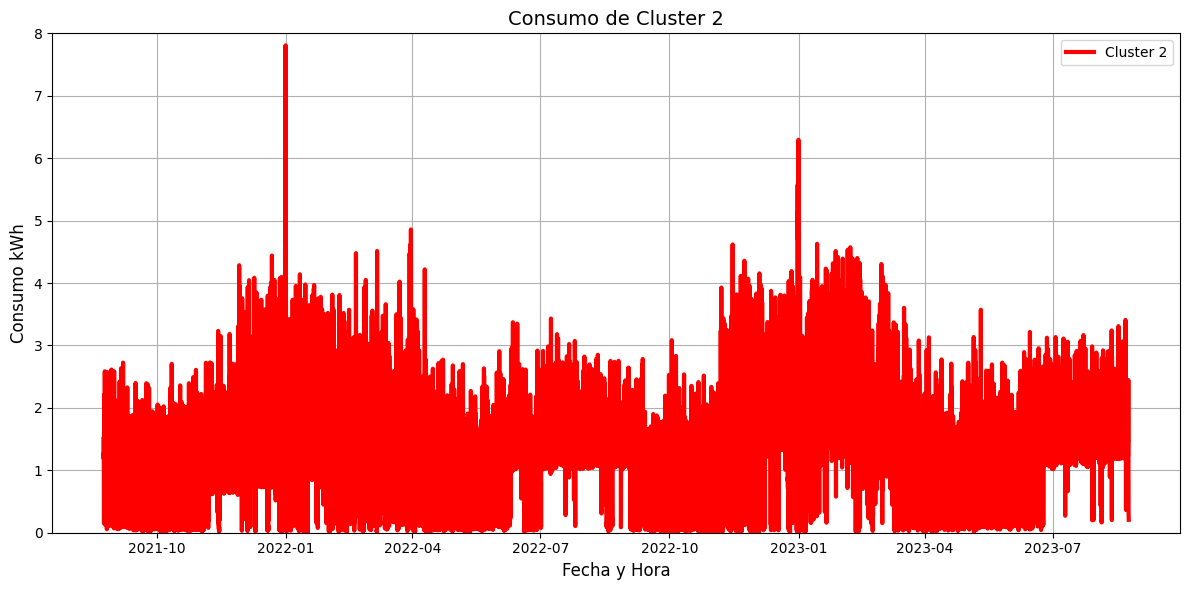

In [13]:
df = pd.read_csv("dataset/datos_consumo_con_clusters_sc.csv", sep=';')

df['hora'] = df['hora'].astype(int)

df['datetime'] = pd.to_datetime(df['fecha']) + pd.to_timedelta(df['hora'], unit='h')

clusters = sorted(df['cluster'].unique())

for cluster in clusters:
    plt.figure(figsize=(12, 6))

    cluster_data = df[df['cluster'] == cluster]
    
    for cups_id in cluster_data['cups'].unique():
        cups_series = cluster_data[cluster_data['cups'] == cups_id]
        plt.plot(cups_series['datetime'], cups_series['consumo_kWh'], color='lightgray', alpha=0.15, linewidth=0.8)
    
    cluster_center = cluster_data.groupby('datetime')['consumo_kWh'].mean()
    plt.plot(cluster_center.index, cluster_center.values, label=f'Cluster {int(cluster)}', linewidth=3, color='red')

    plt.title(f'Consumo de Cluster {int(cluster)}', fontsize=14)
    plt.xlabel('Fecha y Hora', fontsize=12)
    plt.ylabel('Consumo kWh', fontsize=12)
    plt.grid(True)
    plt.legend()
    
    # Fijar el rango del eje Y de 0 a 8 kWh
    plt.ylim(0, 8)
    
    plt.tight_layout()
    plt.show()
